Para entrar no modo apresentação, execute a seguinte célula e pressione `-`

In [1]:
%reload_ext slide

<IPython.core.display.Javascript object>

<span class="notebook-slide-start"/>

# Mineração de Repositórios (Parte 1)

Este notebook apresenta os seguintes tópicos:

- [Introdução](#Introdu%C3%A7%C3%A3o)
- [Servidor de proxy](#Servidor-de-proxy)
- [Crawling](#Crawling)
- [Exercício 5](#Exerc%C3%ADcio-5)
- [APIs do GitHub](#APIs-do-GitHub)
- [Autenticação](#Autentica%C3%A7%C3%A3o)
- [API v3](#API-v3)
- [Exercício 6](#Exerc%C3%ADcio-6)
- [Exercício 7](#Exerc%C3%ADcio-7)
- [Exercício 8](#Exerc%C3%ADcio-8)

## Introdução

Existe muita informação disponível em repositórios software.

A seguir temos uma *screenshot* do repositório `gems-uff/sapos`.

<img src="images/githubexample.png" alt="Página Inicial de Repositório no GitHub" width="auto"/>

Nessa imagem, vemos a organização e nome do repositório

<img src="images/githubexample1.png" alt="Página Inicial de Repositório no GitHub com nome do repositório selecionado" width="auto"/>

Estrelas, forks, watchers 

<img src="images/githubexample2.png" alt="Página Inicial de Repositório no GitHub com watchers, star e fork selecionados" width="auto"/>

Número de issues e pull requests 

<img src="images/githubexample3.png" alt="Página Inicial de Repositório no GitHub com numero de issues e pull requests selecionados" width="auto"/>

Número de commits, branches, releases, contribuidores e licensa <span class="notebook-slide-extra" data-count="1"/>

<img src="images/githubexample4.png" alt="Página Inicial de Repositório no GitHub com número de commits, branches, releases, contribuidores e licensa selecionados" width="auto"/>

Arquivos

<img src="images/githubexample5.png" alt="Página Inicial de Repositório no GitHub com arquivos selecionados" width="auto"/>


Mensagem e data dos commits que alteraram esses arquivos por último 

<img src="images/githubexample6.png" alt="Página Inicial de Repositório no GitHub com arquivos selecionados" width="auto"/>

Podemos extrair informações de repositórios de software de 3 formas:

- Crawling do site do repositório
- APIs que fornecem dados
- Diretamente do sistema de controle de versões

Neste minicurso abordaremos as 3 maneiras, porém daremos mais atenção a APIs do GitHub e extração direta do Git.

## Servidor de Proxy

Servidores de repositório costumam limitar a quantidade de requisições que podemos fazer.

Em geral, essa limitação não afeta muito o uso esporádico dos serviços para mineração. Porém, quando estamos desenvolvendo algo, pode ser que passemos do limite com requisições repetidas.

Para evitar esse problema, vamos configurar um servidor de proxy simples em flask.

Quando estamos usando um servidor de proxy, ao invés de fazermos requisições diretamente ao site de destino, fazemos requisições ao servidor de proxy, que, em seguida, redireciona as requisições para o site de destino.

Ao receber o resultado da requisição, o proxy faz um cache do resultado e nos retorna o resultado.

Se uma requisição já tiver sido feita pelo servidor de proxy, ele apenas nos retorna o resultado do cache.

### Implementação do Proxy

A implementação do servidor de proxy está no arquivo `proxy.py`. Como queremos executar o proxy em paralelo ao notebook, o servidor precisa ser executado externamente.

Entretanto, o código do proxy será explicado aqui.

Começamos o arquivo com os imports necessários. 

```python
import hashlib
import requests
import simplejson
import os
import sys
from flask import Flask, request, Response
```

A biblioteca `hashlib` é usada para fazer hash das requisições. A biblioteca `requests` é usada para fazer requisições ao GitHub. A biblioteca `simplejson` é usada para transformar requisiçoes e respostas em JSON. A biblioteca `os` é usada para manipular caminhos de diretórios e verificar a existência de arquivos. A biblioteca `sys` é usada para pegar os argumentos da execução. Por fim, `flask` é usada como servidor.



Em seguida, definimos o site para qual faremos proxy, os headers excluídos da resposta recebida, e criamos um `app` pro `Flask`. Note que `SITE` está sendo definido como o primeiro argumendo da execução do programa ou como https://github.com/, caso não haja argumento.

```python
if len(sys.argv) > 1:
    SITE = sys.argv[1]
else:
    SITE = "https://github.com/"
EXCLUDED_HEADERS = ['content-encoding', 'content-length', 'transfer-encoding', 'connection']

app = Flask(__name__)
```

Depois, definimos uma função para tratar todas rotas e métodos possíveis que o servidor pode receber.

```python
METHODS = ['GET', 'POST', 'PATCH', 'PUT', 'DELETE']
@app.route('/', defaults={'path': ''}, methods=METHODS)
@app.route('/<path:path>', methods=METHODS)
def catch_all(path):
```

Dentro desta função, definimos um dicionário de requisição com base na requisição que foi recebida pelo `flask`.

```python
    request_dict = {
        "method": request.method,
        "url": request.url.replace(request.host_url, SITE),
        "headers": {key: value for (key, value) in request.headers if key != 'Host'},
        "data": request.get_data(),
        "cookies": request.cookies,
        "allow_redirects": False
    }
```

Nesta requsição, substituímos o host pelo site de destino.


Em seguida, convertemos o dicionário para JSON e calculamos o hash SHA1 do resultado.

```python
    request_json = simplejson.dumps(request_dict, sort_keys=True)
    sha1 = hashlib.sha1(request_json.encode("utf-8")).hexdigest()
    path_req = os.path.join("cache", sha1 + ".req")
    path_resp = os.path.join("cache", sha1 + ".resp")
```

No diretório `cache` armazenamos arquivos `{sha1}.req` e `{sha1}.resp` com a requisição e resposta dos resultados em cache.

Com isso, ao receber uma requisição, podemos ver se `{sha1}.req` existe. Se existir, podemos comparar com a nossa requisição (para evitar conflitos). Por fim, se forem iguais, podemos retornar a resposta que está em cache.

```python
    if os.path.exists(path_req):
        with open(path_req, "r") as req:
            req_read = req.read()
            if req_read == request_json:
                with open(path_resp, "r") as dump:
                    response = simplejson.load(dump)
                    return Response(
                        response["content"],
                        response["status_code"],
                        response["headers"]
                    )
```

Se a requisição não estiver em cache, transformamos o dicionário da requisição em uma requisição do `requests` para o GitHub, excluimos os headers populados pelo `flask` e criamos um JSON para a resposta.

```python
    resp = requests.request(**request_dict)
    headers = [(name, value) for (name, value) in resp.raw.headers.items()
               if name.lower() not in EXCLUDED_HEADERS]
    response = {
        "content": resp.content,
        "status_code": resp.status_code,
        "headers": headers
    }
    response_json = simplejson.dumps(response, sort_keys=True)
```

Depois disso, salvamos a resposta no cache e retornamos ela para o cliente original.

```python
    with open(path_resp, "w") as dump:
        dump.write(response_json)
    with open(path_req, "w") as req:
        req.write(request_json)
    return Response(
        response["content"],
        response["status_code"],
        response["headers"]
    )
```

No fim do script, iniciamos o servidor.

```python
if __name__ == '__main__':
    app.run(debug=True)
```

### Uso do Proxy

Execute a seguinte linha em um terminal:

```bash
python proxy.py
```

Agora, toda requisição que faríamos a github.com, passaremos a fazer a localhost:5000. Por exemplo, ao invés de acessar https://github.com/gems-uff/sapos, acessaremos http://localhost:5000/gems-uff/sapos


### Requisição com requests

A seguir fazemos uma requisição com requests para o proxy. <span class="notebook-slide-extra" data-count="2"/>

In [59]:
SITE = "http://localhost:5000/" # Se não usar o proxy, alterar para https://github.com/

In [69]:
import requests

response = requests.get(SITE + "gems-uff/sapos")
response.headers['server'], response.status_code

('GitHub.com', 200)

<span class="notebook-slide-scroll" data-position="-1"/>

Podemos que o resultado foi obtido do GitHub e que a requisição funcionou, dado que o resultado foi 200. 

## Crawling

Nesta seção, faremos requisições da página inicial de um repositório no GitHub e tentaremos extrair informações dela.

A página usada é a mesma que usamos para mostrar requisição com requests. Ou seja, podemos usar o mesmo código para fazer a requisição. <span class="notebook-slide-extra" data-count="1"/>

In [71]:
response = requests.get(SITE + "gems-uff/sapos")
response.status_code

200

O conteúdo do HTML pode ser obtido pelo atributo `response.text`. <span class="notebook-slide-extra" data-count="1"/>

In [79]:
response.text[:100]

'\n\n\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch'

Para extrair informações do HTML, podemos usar a biblioteca `BeautifulSoup`. <span class="notebook-slide-extra" data-count="1"/>

In [80]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

Essa célula parseou HTML para o objeto `soup`, que nos permite invocar métodos para buscar elementos do DOM <span class="notebook-slide-scroll" data-position="-1"/>

Para descobrirmos o que buscar, podemos usar a função de "Inspecionar elemento" do navegador e observar `id`, `class` e elementos que queremos.

<img src="images/inspectmarked.png" alt="Inspect do Navegador mostrando o elemento que queremos obter" width="auto"/>

Usando o elemento e a classe, podemos usar um seletor do BeautifulSoup para obter o número de estrelas. <span class="notebook-slide-extra" data-count="1"/>

In [117]:
soup.select("a.social-count")

[<a aria-label="6 users are watching this repository" class="social-count" href="/gems-uff/sapos/watchers">
       6
     </a>,
 <a aria-label="18 users starred this repository" class="social-count js-social-count" href="/gems-uff/sapos/stargazers">
       18
     </a>,
 <a aria-label="11 users forked this repository" class="social-count" href="/gems-uff/sapos/network/members">
       11
     </a>]

O seletor usado trouxe mais elementos do que gostaríamos. Precisamos filtrar ainda mais. Nesse caso, podemos filtrar pela classe `.js-social-count` ou pelo `href`. <span class="notebook-slide-scroll" data-position="-1"/>

Pela classe: <span class="notebook-slide-extra" data-count="2"/>

In [123]:
soup.select("a.social-count.js-social-count")

[<a aria-label="18 users starred this repository" class="social-count js-social-count" href="/gems-uff/sapos/stargazers">
       18
     </a>]

In [124]:
_[0].text.strip() + " estrelas"

'18 estrelas'

Pelo href terminado em `stargazers`: <span class="notebook-slide-extra" data-count="2"/>

In [126]:
soup.select('a.social-count[href$="stargazers"]')

[<a aria-label="18 users starred this repository" class="social-count js-social-count" href="/gems-uff/sapos/stargazers">
       18
     </a>]

In [127]:
_[0].text.strip() + " estrelas"

'18 estrelas'

Usando `href`, também podemos obter watchers e forks: <span class="notebook-slide-extra" data-count="2"/>

In [129]:
soup.select('a.social-count[href$="watchers"]')[0].text.strip() + " watchers"

'6 watchers'

In [131]:
soup.select('a.social-count[href$="members"]')[0].text.strip() + " forks"

'11 forks'

## Exercício 5

Obtenha a lista de arquivos e diretórios da raiz do repositório com seus respectivos commits.

## APIs do GitHub

Como o GitHub oferece APIs para obter informações de repositórios, usá-las em geral é melhor do que fazer crawling.

O GitHub possui duas versões estáveis de APIs:

- REST API v3: https://developer.github.com/v3/
- GraphQL API v4: https://developer.github.com/v4/

A forma de usar cada API é diferente e a taxa de requisições permitidas também é. Neste minicurso, usaremos requests para acessar ambas as APIs, mas existem bibliotecas prontas (como a PyGitHub para a v3) que fazem o acesso.

### Autenticação

Para usar qualquer uma das APIs, é necessário gerar um token de autenticação no GitHub seguindo os seguintes passos.

Primeiro, vá em configurações da conta.

<img src="images/github1.png" alt="Página inicial do GitHub" width="auto"/>

Em seguida, abra configurações de desenvolvedor.

<img src="images/github2.png" alt="Página de Configurações do Usuário" width="auto"/>

Abra "Personal access tokens" e clique em "Generate new token". 

<img src="images/github3.png" alt="Página de Tokens de Acesso Pessoal" wi3dth="auto"/>

Escolha as permissões que você deseja no token. 

<img src="images/github4.png" alt="Página de Criação de Token de Acesso Pessoal" width="auto"/>

Copie o token gerado para algum lugar seguro. Para o minicurso, eu copiei o meu token para `~/githubtoken.txt` e vou carregá-lo para a variável `token` a seguir. <span class="notebook-slide-extra" data-count="1"/>

In [19]:
from ipywidgets import FileUpload, interact
@interact(files=FileUpload())
def set_token(files={}):
    global token
    if files:
        for key, values in files.items():
            token = values['content'].decode("utf-8").strip()
            print("Token Loaded!")

interactive(children=(FileUpload(value={}, description='Upload'), Output()), _dom_classes=('widget-interact',)…

## API v3

Com o token em mãos, podemos começar a usa a API v3. O acesso a API do GitHub é feito a https://api.github.com. Portanto, precisamos mudar o site de nosso servidor de proxy. Para isso, podemos fechar e reiniciar da seguinte forma:

```bash
python proxy.py https://api.github.com/
```

Inicialmente, vamos fazer uma requisição para verificar se a autenticação funciona e para vermos nosso limite de requisições. <span class="notebook-slide-extra" data-count="1"/>

In [180]:
SITE = "http://localhost:5000/" # ou https://api.github.com
def token_auth(request):
    request.headers["User-Agent"] = "Minicurso" # Necessário
    request.headers["Authorization"] = "token {}".format(token)
    return request
response = requests.get(SITE, auth=token_auth)
response.status_code

200

Resultado 200 - a autenticação funcionou. <span class="notebook-slide-scroll" data-position="-1"/>

O limite de acesso vem definido no header. <span class="notebook-slide-extra" data-count="3"/>

In [170]:
response.headers["X-RateLimit-Limit"]

'5000'

In [171]:
response.headers["X-RateLimit-Remaining"]

'4996'

In [172]:
response.headers["X-RateLimit-Reset"]

'1571873937'

O retorno da API v3 é sempre um JSON. O acesso a https://api.github.com retorna as URLS válidas da API. <span class="notebook-slide-extra" data-count="1"/>

In [181]:
response.json()

{'current_user_url': 'https://api.github.com/user',
 'current_user_authorizations_html_url': 'https://github.com/settings/connections/applications{/client_id}',
 'authorizations_url': 'https://api.github.com/authorizations',
 'code_search_url': 'https://api.github.com/search/code?q={query}{&page,per_page,sort,order}',
 'commit_search_url': 'https://api.github.com/search/commits?q={query}{&page,per_page,sort,order}',
 'emails_url': 'https://api.github.com/user/emails',
 'emojis_url': 'https://api.github.com/emojis',
 'events_url': 'https://api.github.com/events',
 'feeds_url': 'https://api.github.com/feeds',
 'followers_url': 'https://api.github.com/user/followers',
 'following_url': 'https://api.github.com/user/following{/target}',
 'gists_url': 'https://api.github.com/gists{/gist_id}',
 'hub_url': 'https://api.github.com/hub',
 'issue_search_url': 'https://api.github.com/search/issues?q={query}{&page,per_page,sort,order}',
 'issues_url': 'https://api.github.com/issues',
 'keys_url': '

Vamos ver o que a API tem sobre algum repositório.

Primeiro precisamos ver qual URL usar. <span class="notebook-slide-extra" data-count="1"/>

In [182]:
_['repository_url']

'https://api.github.com/repos/{owner}/{repo}'

Em seguida, fazemos a requisição para saber o que tem no repositorio `gems-uff/sapos`. <span class="notebook-slide-extra" data-count="2"/>

In [186]:
response = requests.get(SITE + "repos/gems-uff/sapos", auth=token_auth)
response.status_code

200

In [188]:
data = response.json()
data

{'id': 3722240,
 'node_id': 'MDEwOlJlcG9zaXRvcnkzNzIyMjQw',
 'name': 'sapos',
 'full_name': 'gems-uff/sapos',
 'private': False,
 'owner': {'login': 'gems-uff',
  'id': 1486707,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjE0ODY3MDc=',
  'avatar_url': 'https://avatars0.githubusercontent.com/u/1486707?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/gems-uff',
  'html_url': 'https://github.com/gems-uff',
  'followers_url': 'https://api.github.com/users/gems-uff/followers',
  'following_url': 'https://api.github.com/users/gems-uff/following{/other_user}',
  'gists_url': 'https://api.github.com/users/gems-uff/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/gems-uff/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/gems-uff/subscriptions',
  'organizations_url': 'https://api.github.com/users/gems-uff/orgs',
  'repos_url': 'https://api.github.com/users/gems-uff/repos',
  'events_url': 'https://api.github.com/users/gems-uff/events{/privacy

O resultado tem diversos resultados e URLs para pegar mais informações. Vamos pegar algumas informações diretas interessantes. <span class="notebook-slide-extra" data-count="1"/>

In [190]:
print("Estrelas:", data["stargazers_count"])
print("Forks:", data["forks"])
print("Watchers:", data["subscribers_count"])
print("Issues abertas:", data["open_issues"])
print("Linguagem:", data["language"])

Estrelas: 18
Forks: 11
Watchers: 6
Issues abertas: 41
Linguagem: Ruby


Se quisermos saber quem são os colaboradores do projeto e quais são as issues existentes, podemos obter as respectivas URLs. <span class="notebook-slide-extra" data-count="1"/>

In [191]:
print("Colaboradores:", data["contributors_url"])
print("Issues:", data["issues_url"])

Colaboradores: https://api.github.com/repos/gems-uff/sapos/contributors
Issues: https://api.github.com/repos/gems-uff/sapos/issues{/number}


Agora podemos obter a lista de colaboradores. <span class="notebook-slide-extra" data-count="2"/>

In [192]:
response = requests.get(SITE + "repos/gems-uff/sapos/contributors", auth=token_auth)
response.status_code

200

In [195]:
data = response.json()
data

[{'login': 'JoaoFelipe',
  'id': 327789,
  'node_id': 'MDQ6VXNlcjMyNzc4OQ==',
  'avatar_url': 'https://avatars1.githubusercontent.com/u/327789?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/JoaoFelipe',
  'html_url': 'https://github.com/JoaoFelipe',
  'followers_url': 'https://api.github.com/users/JoaoFelipe/followers',
  'following_url': 'https://api.github.com/users/JoaoFelipe/following{/other_user}',
  'gists_url': 'https://api.github.com/users/JoaoFelipe/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/JoaoFelipe/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/JoaoFelipe/subscriptions',
  'organizations_url': 'https://api.github.com/users/JoaoFelipe/orgs',
  'repos_url': 'https://api.github.com/users/JoaoFelipe/repos',
  'events_url': 'https://api.github.com/users/JoaoFelipe/events{/privacy}',
  'received_events_url': 'https://api.github.com/users/JoaoFelipe/received_events',
  'type': 'User',
  'site_admin': False,
 

### Gráfico de Barras

A partir desta lista, podemos fazer um gráfico de barras de contribuições. <span class="notebook-slide-extra" data-count="2"/>

In [198]:
contributions = {x["login"]: x["contributions"] for x in data}
contributions

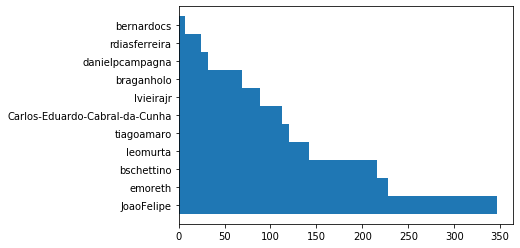

In [203]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
labels, values = zip(*contributions.items())
indexes = np.arange(len(labels))
width = 1
plt.barh(indexes, values, width)
plt.yticks(indexes, labels)
plt.show()

Nesse código:

- Importamos `matplotlib` e `numpy` para gerar o gráfico
- Chamamos `%matplotlib inline` para permitir a visualização da figura
- Separamos o dicionário `contributions` em duas listas de `labels` e `values`
- Criamos um `arange` de índices
- Criamos o gráfico de barras horizontal, usando `barh`
- Definimos os ticks de y como sendo os `labels` extraídos anteriormente

Podemos acessar também a url de issues. <span class="notebook-slide-extra" data-count="3"/>

In [211]:
response = requests.get(SITE + "repos/gems-uff/sapos/issues", auth=token_auth)
response.status_code

200

In [213]:
data = response.json()
data

[{'url': 'https://api.github.com/repos/gems-uff/sapos/issues/303',
  'repository_url': 'https://api.github.com/repos/gems-uff/sapos',
  'labels_url': 'https://api.github.com/repos/gems-uff/sapos/issues/303/labels{/name}',
  'comments_url': 'https://api.github.com/repos/gems-uff/sapos/issues/303/comments',
  'events_url': 'https://api.github.com/repos/gems-uff/sapos/issues/303/events',
  'html_url': 'https://github.com/gems-uff/sapos/issues/303',
  'id': 496454487,
  'node_id': 'MDU6SXNzdWU0OTY0NTQ0ODc=',
  'number': 303,
  'title': 'Relatório de prorrogações concedidas',
  'user': {'login': 'braganholo',
   'id': 1494494,
   'node_id': 'MDQ6VXNlcjE0OTQ0OTQ=',
   'avatar_url': 'https://avatars3.githubusercontent.com/u/1494494?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/braganholo',
   'html_url': 'https://github.com/braganholo',
   'followers_url': 'https://api.github.com/users/braganholo/followers',
   'following_url': 'https://api.github.com/users/braganholo/fo

In [220]:
len(data)

30

Por padrão, a API retorna 30 itens por página. Dessa forma. a lista retornou apenas a primeira página de issues. <span class="notebook-slide-position" data-count="-1"/>

Podemos acessar a segunda página com o parâmetro `?page=2`. <span class="notebook-slide-extra" data-count="3"/>

In [217]:
response = requests.get(SITE + "repos/gems-uff/sapos/issues?page=2", auth=token_auth)
response.status_code

200

In [218]:
data2 = response.json()
data2

[{'url': 'https://api.github.com/repos/gems-uff/sapos/issues/174',
  'repository_url': 'https://api.github.com/repos/gems-uff/sapos',
  'labels_url': 'https://api.github.com/repos/gems-uff/sapos/issues/174/labels{/name}',
  'comments_url': 'https://api.github.com/repos/gems-uff/sapos/issues/174/comments',
  'events_url': 'https://api.github.com/repos/gems-uff/sapos/issues/174/events',
  'html_url': 'https://github.com/gems-uff/sapos/issues/174',
  'id': 57198796,
  'node_id': 'MDU6SXNzdWU1NzE5ODc5Ng==',
  'number': 174,
  'title': 'Lista de Requisitos para Matrícula',
  'user': {'login': 'braganholo',
   'id': 1494494,
   'node_id': 'MDQ6VXNlcjE0OTQ0OTQ=',
   'avatar_url': 'https://avatars3.githubusercontent.com/u/1494494?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/braganholo',
   'html_url': 'https://github.com/braganholo',
   'followers_url': 'https://api.github.com/users/braganholo/followers',
   'following_url': 'https://api.github.com/users/braganholo/follo

In [219]:
len(data2)

11

Podemos formar uma lista com todas as issues abertas. <span class="notebook-slide-extra" data-count="1"/>

In [222]:
open_issues = data + data2

Essas são apenas as issues abertas. Para pegarmos as issues fechadas, precisamos definir `state=closed`. Podemos aproveitar e definir também `per_page=100` (limite máximo) e fazer um código para pegar todas as páginas. <span class="notebook-slide-extra" data-count="1"/>

In [230]:
should_continue = True
page = 1
closed_issues = []
while should_continue:
    response = requests.get(SITE + "repos/gems-uff/sapos/issues?page={}&per_page=100&state=closed".format(page), auth=token_auth)
    if response.status_code != 200:
        print("Fail:", response.status_code)
        break
    data = response.json()
    closed_issues += data
    if len(data) < 100:
        should_continue = False
    page += 1
len(closed_issues), page - 1

(262, 3)

Foram encontradas 262 issues em 3 páginas. <span class="notebook-slide-scroll" data-position="-1"/>

Agora podemos fazer um gráfico que mostre a evolução de issues abertas ao longo do tempo. 

Para fazer esse gráfico, primeiro precisamos combinar as issues e descobrir qual foi a data da issue mais antiga. <span class="notebook-slide-extra" data-count="1"/>

In [238]:
import dateutil.parser

all_issues = open_issues + closed_issues
oldest_issue = min(
    all_issues, 
    key=lambda x: dateutil.parser.parse(x["created_at"])
)

oldest_date = dateutil.parser.parse(oldest_issue["created_at"])
oldest_date

datetime.datetime(2013, 6, 29, 15, 23, 48, tzinfo=tzutc())

A partir desta data, podemos criar um range de dias até hoje para ser o nosso índice do gráfico e um array de zeros do `numpy` para acumularmos a quantidade de issues abertas. <span class="notebook-slide-extra" data-count="1"/>

In [263]:
from datetime import datetime, timezone
today = datetime.now(timezone.utc)
delta = today - oldest_date
days = delta.days
print(days)
indexes = np.arange(days)
values = np.zeros(days)

2307


Podemos percorrer todas as issues abertas, incrementando `values` do período em que elas foram abertas até hoje. E podemos percorrer todas as issues fechadas incrementando `values` do período em que elas foram abertas até o período em que elas foram fechadas. <span class="notebook-slide-extra" data-count="1"/>

In [264]:
for issue in open_issues:
    created_at = dateutil.parser.parse(issue["created_at"])
    created_at_index = (created_at - oldest_date).days
    values[created_at_index:] += 1
    
for issue in closed_issues:
    created_at = dateutil.parser.parse(issue["created_at"])
    created_at_index = (created_at - oldest_date).days
    
    closed_at = dateutil.parser.parse(issue["closed_at"])
    closed_at_index = (closed_at - oldest_date).days
    values[created_at_index:closed_at_index] += 1

Já é possível plotar o gráfico desta forma, mas o entendimento dos eixos ainda não é o ideal. <span class="notebook-slide-extra" data-count="1"/>

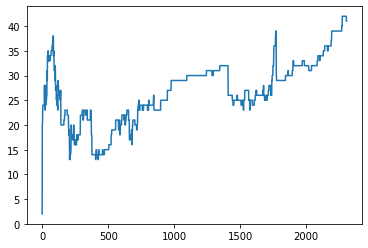

In [262]:
plt.plot(indexes, values)

Precisamos definir quais são os anos no eixo x. <span class="notebook-slide-extra" data-count="1"/>

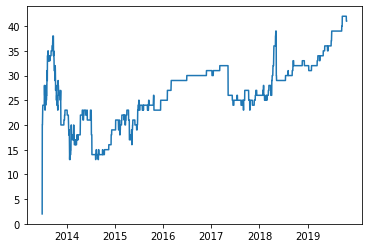

In [288]:
from math import ceil
labels = [datetime(2013 + i, 1, 1, tzinfo=timezone.utc) for i in range(ceil(delta.days / 365))]
label_indexes = [(label - oldest_date).days for label in labels]
label_years = [label.year for label in labels]
plt.xticks(label_indexes, label_years)
plt.plot(indexes, values)
plt.show()

Também podemos definir o que é cada eixo. <span class="notebook-slide-extra" data-count="1"/>

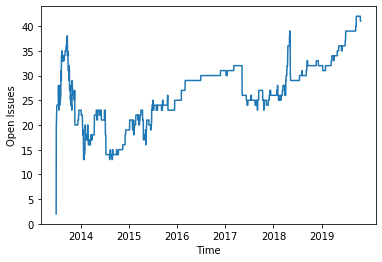

In [289]:
plt.xticks(label_indexes, label_years)
plt.xlabel("Time")
plt.ylabel("Open Issues")
plt.plot(indexes, values)
plt.show()

Issues podem ter diversos labels. Agora vamos fazer um gráfico que mostre barras estacadas com a evolução de cada tipo de issue. <span class="notebook-slide-extra" data-count="1"/>

In [293]:
from collections import defaultdict
values = defaultdict(lambda: np.zeros(days))

for issue in open_issues:
    created_at = dateutil.parser.parse(issue["created_at"])
    created_at_index = (created_at - oldest_date).days
    for label in issue["labels"]:
        values[label["name"]][created_at_index:] += 1
    if not issue["labels"]:
        values["no-label"][created_at_index:] += 1
        
for issue in closed_issues:
    created_at = dateutil.parser.parse(issue["created_at"])
    created_at_index = (created_at - oldest_date).days
    
    closed_at = dateutil.parser.parse(issue["closed_at"])
    closed_at_index = (closed_at - oldest_date).days
    for label in issue["labels"]:
        values[label["name"]][created_at_index:closed_at_index] += 1
    if not issue["labels"]:
        values["no-label"][created_at_index:closed_at_index] += 1
        


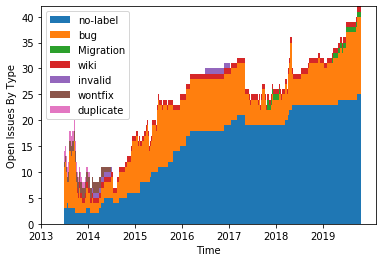

In [298]:
bottom = np.zeros(days)
legend_color = []
legend_text = []
for label, yvalues in values.items():
    if not label[0].isdigit(): # Exclui tags de versões
        ax = plt.bar(indexes, yvalues, 1,
                     bottom=bottom)
        legend_color.append(ax[0])
        bottom += yvalues
        legend_text.append(label)
        
plt.xticks(label_indexes, label_years)
plt.xlabel("Time")
plt.ylabel("Open Issues By Type")
plt.legend(legend_color, legend_text)
plt.show()

## Exercício 6

Filtre o gráfico para mostrar apenas o ano 2017.

## Exercício 7

Crie um gráfico de linhas que mostre apenas issues do tipo bug.

## Exercício 8

Crie um gráfico de barras para mostrar a participação de usuários em cada issue. Considere os atributos `creator` e `user`.